In [1]:
"""
This example shows how to perform regression of molecular properties with the
QM9 database, using a simple GNN in disjoint mode.
"""

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

from spektral.data import DisjointLoader
from spektral.datasets import QM9
from spektral.layers import ECCConv, GlobalSumPool

################################################################################
# Config
################################################################################
learning_rate = 1e-3  # Learning rate
epochs = 10  # Number of training epochs
batch_size = 32  # Batch size

################################################################################
# Load data
################################################################################
dataset = QM9(amount=1000)  # Set amount=None to train on whole dataset

# Parameters
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs)
loader_te = DisjointLoader(dataset_te, batch_size=batch_size, epochs=1)


################################################################################
# Build model
################################################################################
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = ECCConv(32, activation="relu")
        self.conv2 = ECCConv(32, activation="relu")
        self.global_pool = GlobalSumPool()
        self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = self.conv1([x, a, e])
        x = self.conv2([x, a, e])
        output = self.global_pool([x, i])
        output = self.dense(output)

        return output

model = Net()
optimizer = Adam(learning_rate)
loss_fn = MeanSquaredError()


################################################################################
# Fit model
################################################################################
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


step = loss = 0
for batch in loader_tr:
    step += 1
    loss += train_step(*batch)
    if step == loader_tr.steps_per_epoch:
        step = 0
        print("Loss: {}".format(loss / loader_tr.steps_per_epoch))
        loss = 0

################################################################################
# Evaluate model
################################################################################
print("Testing model")
loss = 0
for batch in loader_te:
    inputs, target = batch
    predictions = model(inputs, training=False)
    loss += loss_fn(target, predictions)
loss /= loader_te.steps_per_epoch
print("Done. Test loss: {}".format(loss))

Loading QM9 dataset.
Reading SDF


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2520.74it/s]
2023-12-11 15:39:32.213337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-11 15:39:32.227747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-11 15:39:32.227879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-11 15:39:32.228592: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX 

Loss: 22117774.0
Loss: 22071940.0
Loss: 21939204.0
Loss: 21823492.0
Loss: 21800044.0
Loss: 21795458.0
Loss: 21794072.0
Loss: 21790706.0
Loss: 21788766.0
Loss: 21786432.0
Testing model
Done. Test loss: 8055.3515625


/home/zwbai/miniconda3/envs/gcn/lib/python3.9/site-packages/spektral/layers/convolutional/conv.py:98: UserWarning: The adjacency matrix of dtype <dtype: 'int64'> is incompatible with the dtype of the node features <dtype: 'float32'> and has been automatically cast to <dtype: 'float32'>.
  warnings.warn(


In [4]:
model.save('./vasp_cal/model')

/home/zwbai/miniconda3/envs/gcn/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: The adjacency matrix of dtype <dtype: 'int64'> is incompatible with the dtype of the node features <dtype: 'float32'> and has been automatically cast to <dtype: 'float32'>.
  return py_builtins.overload_of(f)(*args)
/home/zwbai/miniconda3/envs/gcn/lib/python3.9/site-packages/spektral/layers/convolutional/conv.py:98: UserWarning: The adjacency matrix of dtype <dtype: 'int64'> is incompatible with the dtype of the node features <dtype: 'float32'> and has been automatically cast to <dtype: 'float32'>.
  warnings.warn(
/home/zwbai/miniconda3/envs/gcn/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: The adjacency matrix of dtype <dtype: 'int64'> is incompatible with the dtype of the node features <dtype: 'float32'> and has been automatically cast to <dtype: 'float32'>.
  return py_builtins.overload_of(f)(*args)
/home/zwbai/miniconda3/envs

INFO:tensorflow:Assets written to: ./vasp_cal/model/assets


INFO:tensorflow:Assets written to: ./vasp_cal/model/assets
/home/zwbai/miniconda3/envs/gcn/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [2]:
loader_te = DisjointLoader(dataset_te, batch_size=batch_size, epochs=1)
for batch in loader_te:
    inputs, target = batch
    x, a, e, i = inputs
    print(i)

[ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5
  5  5  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11
 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13
 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17
 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19
 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21
 21 21 21 21 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 24 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 25
 25 25 26 26 26 26 26 26 26 26 26 26 26 26 27 27 27

# Introduction
This is a Graph Convolutional Networks (GCN) to predict adsorption energy by density of states of mentals.

# Function

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
import numpy as np
import pickle

import spektral

from spektral.data import Dataset,Graph

from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Dense
from tensorflow.keras.layers import AveragePooling1D, Concatenate, Conv1D, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from spektral.data import DisjointLoader
from spektral import models
from spektral.layers import ECCConv, GlobalSumPool, GlobalAvgPool

import matplotlib.pyplot as plt
import pandas

import visualkeras

In [14]:
import sys
sys.executable

'/home/zwbai/miniconda3/envs/gcn/bin/python'

In [15]:
tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())

True


# Load Data

In [32]:
class GraphDataset(Dataset):
    """
    A dataset of graphs representing density of states of metals.
    Each graph is expected to have 'x' as features and 'y' as targets.
    """
    def __init__(self, graph_list, **kwargs):
        self.graph_list = graph_list
        super().__init__(**kwargs)
    
    def download(self):
        if not hasattr(self, 'path') or self.path is None:
            print('self.path is None')
        else:
            with open(self.path, 'wb') as file:
                pickle.dump(self.graph_list, file)

    def read(self):
        # We must return a list of Graph objects
        return self.graph_list

    def __len__(self):
        return len(self.graph_list)

    def __getitem__(self, index):
        # Assuming each graph object has 'x' for input features and 'y' for the target
        graph = self.graph_list[index]
        return graph, graph.y


In [33]:
class MyGraphDataset(Dataset):
    """
    A dataset of density of states of mentals
    """
    def __init__(self, graph_list, **kwargs):
        self.graph_list = graph_list
        super().__init__(**kwargs)
    
    def download(self):
        if self.path is None:
            print('self.path is None')
        else:
            with open(self.path, 'wb') as file:
                pickle.dump(self.graph_list, file)

    def read(self):
        # We must return a list of Graph objects
        output = []
        for i in range(len(self.graph_list)):
            output.append(
                self.graph_list[i]
            )
        return output

    def __len__(self):
        return len(self.graph_list)

    def __getitem__(self, index):
        return self.graph_list[index]

In [17]:
# 从文件中提取数据
data_path = './vasp_cal/' # 当前文件执行的文件夹，包括输出和输入文件夹
dos_energy_data_file = data_path + 'dos_energy_data.pkl'
with open(dos_energy_data_file, 'rb') as file:
    dataset1 = pickle.load(file)

print(dataset1)  # 输出：[1, 2, 3, 4, 5]
dataset1[0].x.shape

MyGraphDataset(n_graphs=126)


(8, 2000)

In [18]:
# 从文件中提取数据
file_path = '/home/zwbai/work/ocp-main/ocp/new/vasp_cala/dos_energy_data.pkl'
with open(file_path, 'rb') as file:
    dataset2 = pickle.load(file)

print(dataset2)  # 输出：[1, 2, 3, 4, 5]
dataset2[0].x.shape

MyGraphDataset(n_graphs=594)


(8, 2000)

In [19]:
graph_data = []
for i in range(len(dataset1)):
    g = dataset1[i]
    graph_data.append(g)
for i in range(len(dataset2)):
    g = dataset2[i]
    graph_data.append(g)
len(graph_data)


720

In [34]:
dataset = GraphDataset(graph_data)

In [42]:
dataset[0]

(Graph(n_nodes=8, n_node_features=2000, n_edge_features=4, n_labels=1),
 -0.4223898000000066)

In [49]:
models.fit(dataset, batch_size = 8, epochs =10)

AttributeError: module 'spektral.models' has no attribute 'fit'

# Build GCN model

In [37]:
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target
F, S, n_out

(2000, 4, 1)

In [38]:
learning_rate = 1e-4  # Learning rate
epochs = 40  # Number of training epochs
batch_size = 16  # Batch size

In [39]:
def dos_featurize(length, channel):
    input_dos = Input(shape=(length, channel)) # 400, 5
    x1 = AveragePooling1D(pool_size=2, strides=4, padding='same')(input_dos)  # 窗口 步长
    x2 = AveragePooling1D(pool_size=4, strides=4, padding='same')(input_dos)
    x3 = AveragePooling1D(pool_size=8, strides=4, padding='same')(input_dos)
    x = Concatenate(axis=-1)([x1, x2, x3])  # 沿着最后一个轴拼接
    x = Conv1D(250, 6, activation='relu', padding='same', strides=2)(x)
    x = BatchNormalization()(x)
    x = Conv1D(175, 3, activation='relu', padding='same', strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding='same')(x)
    x = Conv1D(150, 3, activation='relu', padding='same', strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding='same')(x)
    x = Conv1D(125, 3, activation='relu', padding='same', strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding='same')(x)
    x = Conv1D(100, 3, activation='relu', padding='same', strides=2)(x)
    x = tf.squeeze(x)
    # x = x.numpy()
    shared_model = Model(input_dos, x)
    return shared_model

channels = 5
length = int(F/channels) # 400
shared_conv = dos_featurize(length, channels)

2023-12-10 16:32:36.206688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-10 16:32:36.274681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-10 16:32:36.274801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-10 16:32:36.275696: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [44]:
dataset_tr = GraphDataset(graph_data[:66])
loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs)
print(loader_tr.tf_signature())
for batch in loader_tr:
    print(batch[0][0].shape) # batch[0~3] 有四个属性

((TensorSpec(shape=(None, 2000), dtype=tf.float64, name=None), SparseTensorSpec(TensorShape([None, None]), tf.float32), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))


ValueError: Assigned sequence must contain only Graphs

In [15]:
batch[0][0].shape

(16, 2000)

# 

In [46]:
def get_range(lst, ran=[0,1], per_batch=8):
    # 分割
    return (np.array([item for i in range(0, len(lst), per_batch) for item in lst[i+ran[0]:i+ran[1]]]))

def repeat_and_stack(matrix, repeat_times=6):
    # 扩展
    m0 = tf.reshape(matrix, [-1, 1, matrix.shape[-1]])
    m1 = tf.tile(m0, [1, repeat_times, 1])
    m2 = tf.reshape(m1, [-1, matrix.shape[-1]])
    return m2

def assemble(lst, ran=6, per_batch=8):
    # 装配
    lst0 = tf.reshape(lst, [-1, ran, lst.shape[-1]])
    padded_matrix = tf.pad(lst0, [[0, 0], [0, per_batch-ran], [0, 0]])
    padded_matrix = tf.reshape(padded_matrix, [-1, lst.shape[-1]])
    return padded_matrix

In [47]:
class Net(Model):
    def __init__(self):
        super().__init__()
        self.share = shared_conv
        self.conv1 = ECCConv(256, activation="relu")
        self.conv2 = ECCConv(128, activation="relu")
        # self.conv3 = ECCConv(128, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense0 = Dense(64)
        self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = tf.reshape(x, (-1, length, channels))
        x1 = get_range(x)
        x1 = shared_conv(x1)
        x6 = repeat_and_stack(x1)
        x = assemble(x6)
        
        x = self.conv1([x, a, e])
        x = self.conv2([x, a, e])
        # x = self.conv3([x, a, e])
        output = self.global_pool([x, i])
        output = tf.keras.layers.Flatten()(output)
        output = self.dense0(output)
        output = self.dense(output)

        return output

In [48]:
model = Net()

In [24]:
model = Net()
learning_rate = 1E-3
optimizer = Adam(learning_rate)
loss_fn = MeanSquaredError()

# Train/valid/test split
data = np.array(graph_data)
idxs = np.random.permutation(len(data))
split_va_te = int(0.90 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]
# Data loaders
# loader_tr = DisjointLoader(MyGraphDataset(data_tr), batch_size=1, epochs=1)
# loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)


# dataset_tr = MyGraphDataset(dataset)
loader_tr = DisjointLoader(MyGraphDataset(data_tr), batch_size=batch_size, epochs=epochs)

loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)

In [25]:
# Fit model
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [26]:
model.layers

In [27]:
step = loss = 0
for batch in loader_tr:
    step += 1
    loss += train_step(*batch)
    if step == loader_tr.steps_per_epoch:
        step = 0
        print("Loss: {}".format(loss / loader_tr.steps_per_epoch))
        loss = 0

2023-12-07 18:10:14.745086: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Loss: 0.27902713418006897
Loss: 0.12905339896678925
Loss: 0.1002093032002449
Loss: 0.09147732704877853
Loss: 0.07407176494598389
Loss: 0.06735699623823166
Loss: 0.049519848078489304
Loss: 0.04640588536858559
Loss: 0.04542330279946327
Loss: 0.039615925401449203
Loss: 0.03814752399921417
Loss: 0.0352654792368412
Loss: 0.035709530115127563
Loss: 0.030818089842796326
Loss: 0.03166348859667778
Loss: 0.030536355450749397
Loss: 0.028376108035445213
Loss: 0.027187196537852287
Loss: 0.023610932752490044
Loss: 0.019484493881464005
Loss: 0.016464531421661377
Loss: 0.014970878139138222
Loss: 0.014447764493525028
Loss: 0.013111412525177002
Loss: 0.01264931634068489
Loss: 0.011610695160925388
Loss: 0.011253280565142632
Loss: 0.01116334181278944
Loss: 0.01132219098508358
Loss: 0.010638845153152943
Loss: 0.010414522141218185
Loss: 0.010252573527395725
Loss: 0.010489014908671379
Loss: 0.010521238669753075
Loss: 0.010151911526918411
Loss: 0.00989710446447134
Loss: 0.009855187498033047
Loss: 0.0099116843

In [28]:
model.summary()

Model: "net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           None                      328050    
_________________________________________________________________
ecc_conv (ECCConv)           multiple                  153856    
_________________________________________________________________
ecc_conv_1 (ECCConv)         multiple                  196736    
_________________________________________________________________
global_avg_pool (GlobalAvgPo multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  8256      
_________________________________________________________________
dense_1 (Dense)              multiple                  65        
Total params: 686,963
Trainable params: 686,463
Non-trainable params: 500
_______________________________________________________

In [29]:
# Train/valid/test split
data = np.array(graph_data)
idxs = np.random.permutation(len(data))
split_va_te = int(0.9 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]

# Data loaders
loader_tr = DisjointLoader(MyGraphDataset(data_tr), batch_size=1, epochs=1)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)

In [ ]:
# Train/valid/test split
data = np.array(graph_data)
idxs = np.random.permutation(len(data))
split_va_te = int(0.9 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]

# Data loaders
loader_tr = DisjointLoader(MyGraphDataset(data_tr), batch_size=1, epochs=1)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)

In [ ]:
model.

In [30]:
# 对训练集进行预测
predictions = []
targets = []
for batch in loader_tr:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# 组合预测值和真实值
data0 = np.concatenate([predictions, targets], axis=1)

# 对测试集进行预测
predictions = []
targets = []
for batch in loader_va:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

# 组合预测值和真实值
data1 = np.concatenate([predictions, targets], axis=1)

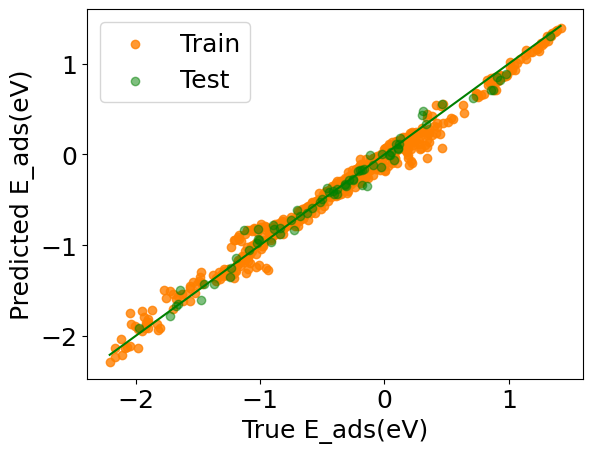

In [31]:
# 画图
plt.rcParams.update({'font.size': 18})

import matplotlib.pyplot as plt
plt.scatter(data0[:, 1], data0[:, 0], color=(1, 0.5, 0, 0.8), label='Train') 
plt.scatter(data1[:, 1], data1[:, 0], color=(0, 0.5, 0, 0.5), label='Test')

plt.plot([min(data0[:, 1]),max(data0[:, 1])],[min(data0[:, 1]),max(data0[:, 1])], color = 'green' )

plt.xlabel("True E_ads(eV)")
plt.ylabel("Predicted E_ads(eV)")
plt.legend()
plt.show()

In [32]:
class FeatureExtraction(Model):
    def __init__(self):
        super().__init__()
        self.share = shared_conv
        self.conv1 = ECCConv(128, activation="relu")
        self.conv2 = ECCConv(128, activation="relu")
        # self.conv3 = ECCConv(128, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense0 = Dense(64)
        self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = tf.reshape(x, (-1, length, channels))
        x1 = get_range(x)
        x1 = shared_conv(x1)
        x6 = repeat_and_stack(x1)
        x = assemble(x6)
        
        x = self.conv1([x, a, e])
        feature1 = x  # 保存第一层卷积的特征
        x = self.conv2([x, a, e])
        feature2 = x  # 保存第二层卷积的特征
        # x = self.conv3([x, a, e])
        output = self.global_pool([x, i])
        output = tf.keras.layers.Flatten()(output)
        output = self.dense0(output)
        feature3 = output 
        output = self.dense(output)

        return output, feature1, feature2, feature3  # 返回输出和需要提取的特征\
            
Model_feature =  FeatureExtraction()   

In [33]:
def plot_feature(X_embedded, targets):
        # 创建彩虹图的 colormap
    cmap = plt.get_cmap("rainbow")

    z = targets
    # 创建彩虹图的 colormap
    cmap = plt.get_cmap("viridis")

    # 设置合适的数值范围
    vmin = np.min(z)
    vmax = np.max(z)

    fig, ax = plt.subplots()

    for i in range(X_embedded.shape[0]):
        # color = cmap(z[i])
        color = cmap((z[i] - vmin) / (vmax - vmin))
        # color = cmap(energies[i])  # 根据 z 的值获取对应的颜色
        plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=color)

    # 添加颜色条
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])  # 设置一个空数组，传递给 colorbar
    cbar = plt.colorbar(sm, ax=ax)

    # 添加标签
    ax.set_xticks([])  # 移除x轴刻度
    ax.set_yticks([])  # 移除y轴刻度
    cbar.set_label("Adsorption Energy (eV)")

    plt.show()

In [34]:
# Data loaders
loader_data = DisjointLoader(MyGraphDataset(data), batch_size=1, epochs=1)
predictions, targets, feature1, feature2, feature3 = [],[],[],[],[]
for batch in loader_data:
    output, f1, f2, f3 =Model_feature(batch[0], training=False)
    predictions.append(output)
    feature1.append(f1)
    feature2.append(f2)
    feature3.append(f3)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# 组合预测值和真实值
data0 = np.concatenate([predictions, targets], axis=1)

In [35]:
fone = [f.numpy().reshape((1,-1))[0] for f in feature1] 
fone = np.array(fone)
fone.shape

(720, 1024)

In [36]:
# TSNE PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [37]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                init='random', perplexity=3).fit_transform(fone)

In [38]:
ftwo = [f.numpy().reshape((1,-1))[0] for f in feature2] 
ftwo = np.array(ftwo)
ftwo.shape

fthree = [f.numpy().reshape((1,-1))[0] for f in feature3] 
fthree = np.array(fthree)
fthree.shape

(720, 64)

In [39]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                init='random', perplexity=3).fit_transform(ftwo)

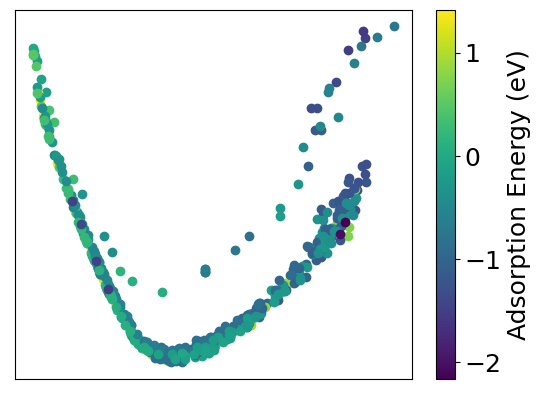

In [40]:
pca2 = PCA(n_components=2)
X_embedded = pca2.fit_transform(fone)
plot_feature(X_embedded[:594], targets[:594])

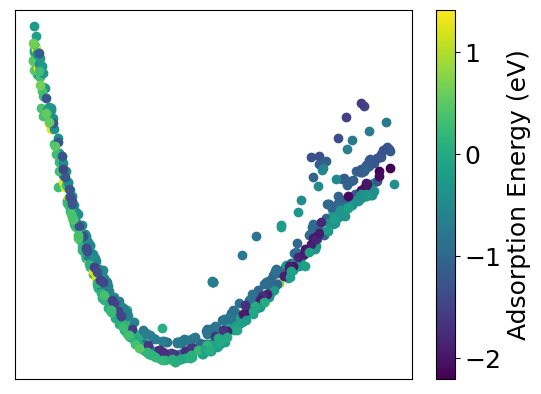

In [41]:
X_embedded = pca2.fit_transform(ftwo)
plot_feature(X_embedded, targets)

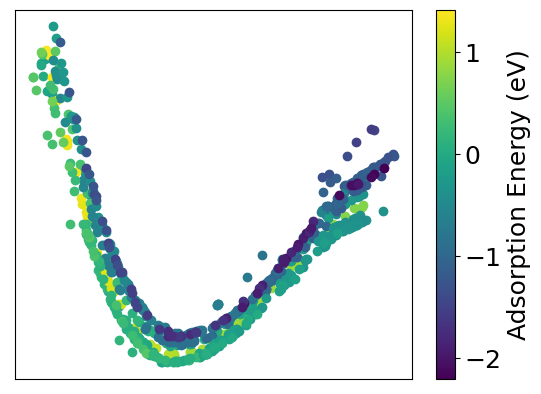

In [42]:
X_embedded = pca2.fit_transform(fthree)
plot_feature(X_embedded, targets)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


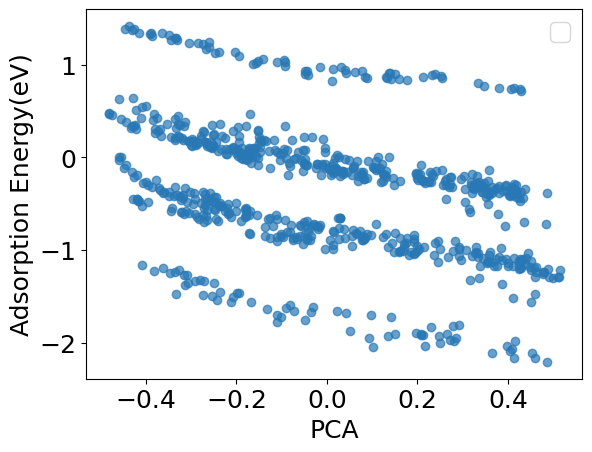

In [44]:
pca = PCA(n_components=1)
X_embedded = pca.fit_transform(fthree)

plt.scatter(X_embedded, targets,color=(40/255, 120/255, 181/255, 0.7) )
plt.xlabel("PCA")
plt.ylabel("Adsorption Energy(eV)")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


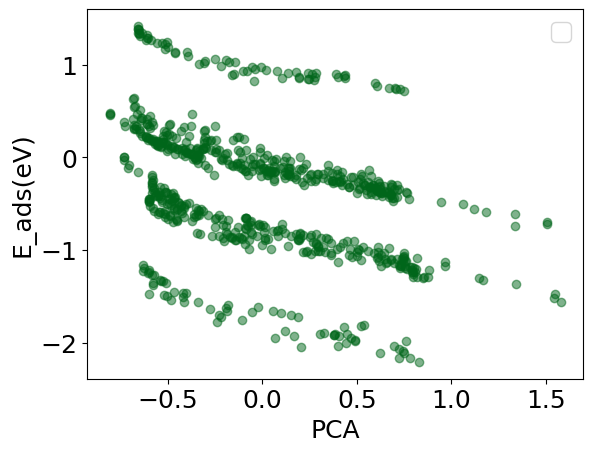

In [50]:
pca = PCA(n_components=1)
X_embedded = pca.fit_transform(fthree)

plt.scatter(X_embedded, targets,color=(0, 0.4, 0.1, 0.5) )
plt.xlabel("PCA")
plt.ylabel("E_ads(eV)")
plt.legend()
plt.show()

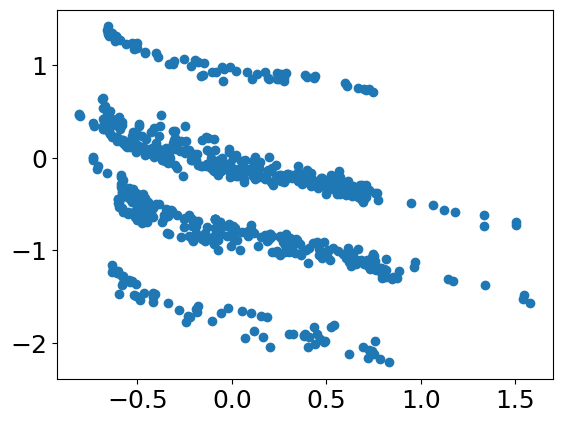

In [45]:
plt.scatter(X_embedded, targets,)

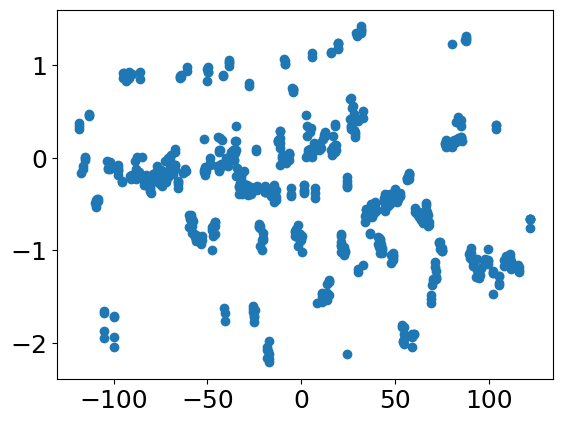

In [46]:
X_embedded = TSNE(n_components=1, learning_rate='auto',
                init='random', perplexity=3).fit_transform(fthree)
plt.scatter(X_embedded, targets)